# DDN model on Rain100

## 1. Setup

In [1]:
import os
import time
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

zip_file_path = 'archive.zip'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('./')
    print("Dataset unzipped successfully!")

    print("\nVerifying data path...")
    !ls -R ./Rain100L/
else:
    print(f"Error: {zip_file_path} not found. Please upload the file.")

Dataset unzipped successfully!

Verifying data path...
./Rain100L/:
input  target

./Rain100L/input:
100.png  19.png  28.png  37.png  46.png  55.png  64.png  73.png  82.png  91.png
10.png	 1.png	 29.png  38.png  47.png  56.png  65.png  74.png  83.png  92.png
11.png	 20.png  2.png	 39.png  48.png  57.png  66.png  75.png  84.png  93.png
12.png	 21.png  30.png  3.png	 49.png  58.png  67.png  76.png  85.png  94.png
13.png	 22.png  31.png  40.png  4.png	 59.png  68.png  77.png  86.png  95.png
14.png	 23.png  32.png  41.png  50.png  5.png	 69.png  78.png  87.png  96.png
15.png	 24.png  33.png  42.png  51.png  60.png  6.png	 79.png  88.png  97.png
16.png	 25.png  34.png  43.png  52.png  61.png  70.png  7.png	 89.png  98.png
17.png	 26.png  35.png  44.png  53.png  62.png  71.png  80.png  8.png	 99.png
18.png	 27.png  36.png  45.png  54.png  63.png  72.png  81.png  90.png  9.png

./Rain100L/target:
100.png  19.png  28.png  37.png  46.png  55.png  64.png  73.png  82.png  91.png
10.png	 1.png	 29

##2. Creating Custom dataset


In [2]:
class DerainDataset(Dataset):
    """ Custom Dataset to load rainy and clean image pairs from specified folders. """
    def __init__(self, data_path, rainy_folder, clean_folder, image_size=(256, 256)):
        super(DerainDataset, self).__init__()

        rainy_dir = os.path.join(data_path, rainy_folder)
        clean_dir = os.path.join(data_path, clean_folder)

        image_filenames = sorted([
            f for f in os.listdir(rainy_dir)
            if f.endswith(('.png', '.jpg', '.jpeg'))
        ])

        self.rainy_paths = [os.path.join(rainy_dir, f) for f in image_filenames]
        self.clean_paths = [os.path.join(clean_dir, f) for f in image_filenames]
        self.image_size = image_size

    def __getitem__(self, index):
        rainy_img = Image.open(self.rainy_paths[index]).convert('RGB')
        clean_img = Image.open(self.clean_paths[index]).convert('RGB')

        rainy_img = rainy_img.resize(self.image_size)
        clean_img = clean_img.resize(self.image_size)


        to_tensor = ToTensor()
        return to_tensor(rainy_img), to_tensor(clean_img)

    def __len__(self):
        return len(self.rainy_paths)

data_path = './Rain100L'

full_dataset = DerainDataset(data_path, rainy_folder='input', clean_folder='target')

dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_subset, val_subset, test_subset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Total images: {dataset_size}")
print(f"Training images: {len(train_subset)}")
print(f"Validation images: {len(val_subset)}")
print(f"Testing images: {len(test_subset)}")

BATCH_SIZE = 8
train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_subset, batch_size=1, shuffle=False)

Total images: 100
Training images: 80
Validation images: 10
Testing images: 10


## 3. Defining Model

In [3]:
class DDN(nn.Module):
    def __init__(self, channels=3, num_of_layers=15):
        super(DDN, self).__init__()
        layers = [
            nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True)
        ]
        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=64, out_channels=channels, kernel_size=3, padding=1, bias=True))
        self.detail_net = nn.Sequential(*layers)

    def forward(self, x):
        detail = self.detail_net(x)
        out = x - detail
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DDN().to(device)

print(f"Model loaded successfully on device: {device}")

Model loaded successfully on device: cuda


## 4. Training

In [4]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting training... ")
start_time = time.time()
best_val_loss = float('inf')

train_loss_history = []
val_loss_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for rainy_imgs, clean_imgs in train_loader:
        rainy_imgs, clean_imgs = rainy_imgs.to(device), clean_imgs.to(device)

        derained_imgs = model(rainy_imgs)
        loss = criterion(derained_imgs, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for rainy_imgs, clean_imgs in val_loader:
            rainy_imgs, clean_imgs = rainy_imgs.to(device), clean_imgs.to(device)
            derained_imgs = model(rainy_imgs)
            loss = criterion(derained_imgs, clean_imgs)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_ddn_model.pth')

print(f"\nFinished Training. Total time: {(time.time() - start_time) / 60:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}. Model saved as 'best_ddn_model.pth'")

Starting training... 
Epoch [10/100] | Train Loss: 0.0028 | Validation Loss: 0.0028
Epoch [20/100] | Train Loss: 0.0017 | Validation Loss: 0.0016
Epoch [30/100] | Train Loss: 0.0012 | Validation Loss: 0.0014
Epoch [40/100] | Train Loss: 0.0012 | Validation Loss: 0.0014
Epoch [50/100] | Train Loss: 0.0011 | Validation Loss: 0.0012
Epoch [60/100] | Train Loss: 0.0010 | Validation Loss: 0.0023
Epoch [70/100] | Train Loss: 0.0010 | Validation Loss: 0.0010
Epoch [80/100] | Train Loss: 0.0009 | Validation Loss: 0.0009
Epoch [90/100] | Train Loss: 0.0008 | Validation Loss: 0.0009
Epoch [100/100] | Train Loss: 0.0008 | Validation Loss: 0.0010

Finished Training. Total time: 9.87 minutes
Best validation loss: 0.0007. Model saved as 'best_ddn_model.pth'


## 5. Validation


Starting evaluation on the test dataset...

------ EVALUATION COMPLETE ------
Average PSNR on Test Data: 31.64 dB
Average SSIM on Test Data: 0.9123

Displaying visual results (Rainy vs. Derained)...


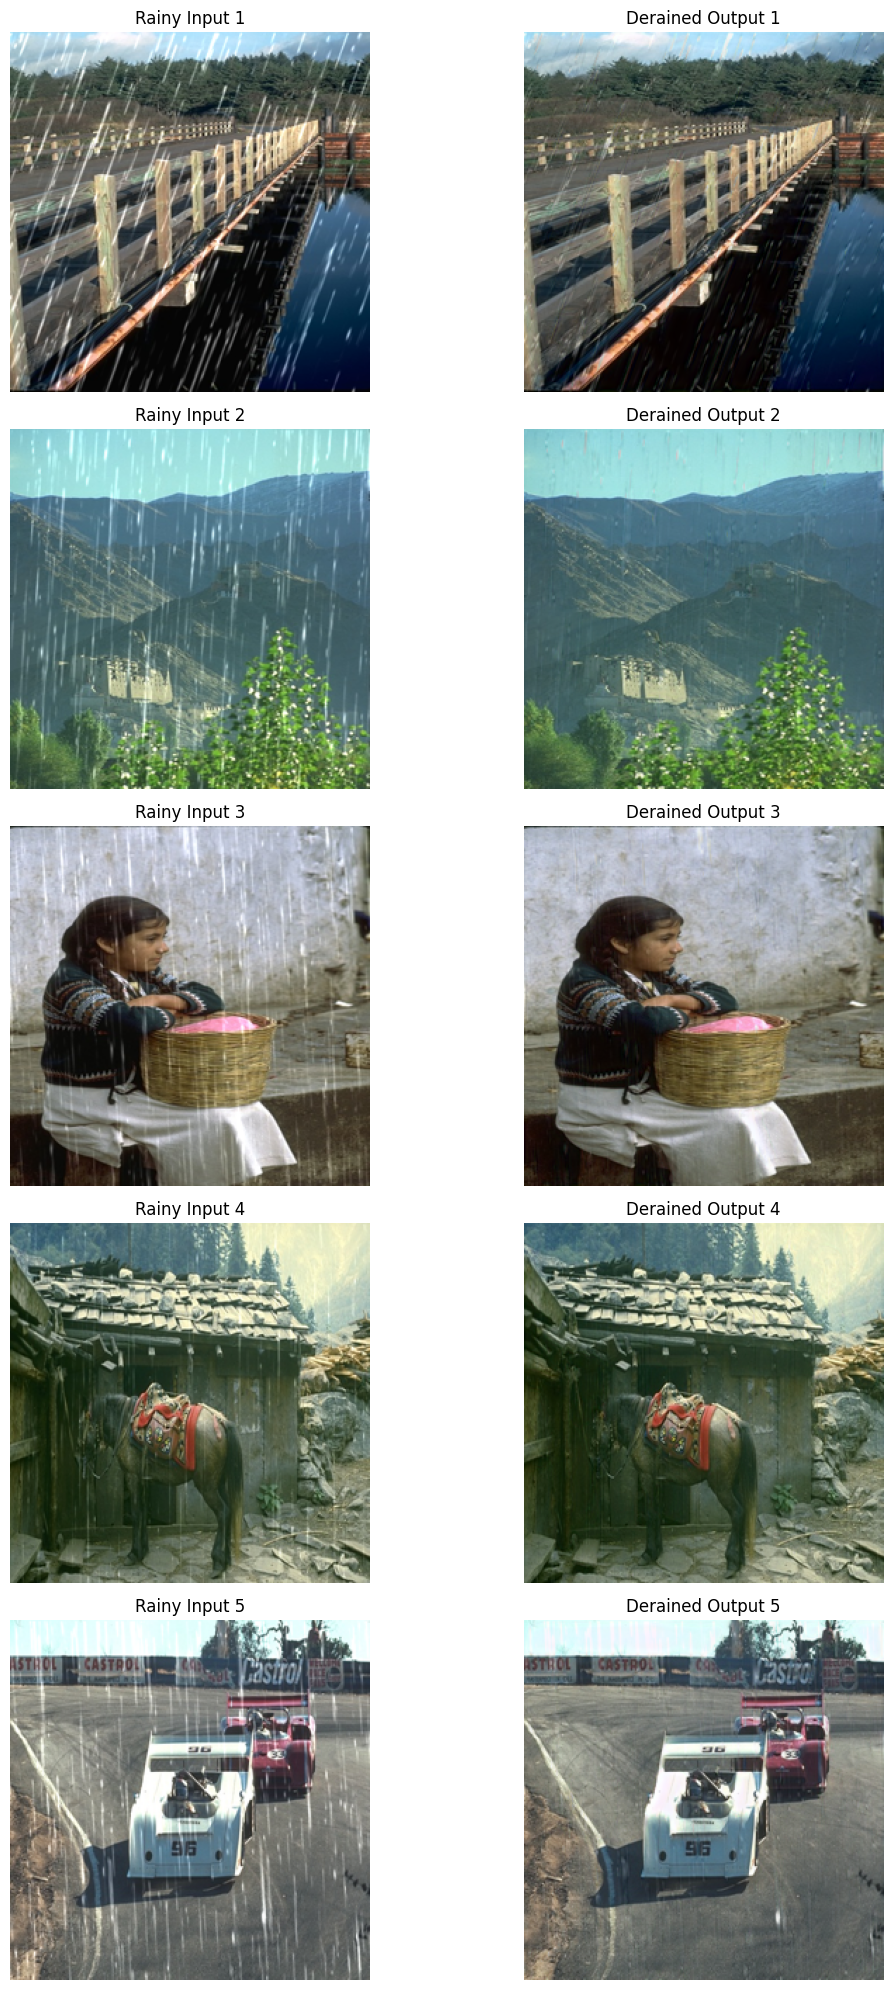

In [5]:
model.load_state_dict(torch.load('best_ddn_model.pth'))
model.eval()

total_psnr = 0.0
total_ssim = 0.0

rainy_samples = []
derained_samples = []

print("\nStarting evaluation on the test dataset...")
with torch.no_grad():
    for i, (rainy_tensor, clean_tensor) in enumerate(test_loader):
        rainy_tensor, clean_tensor = rainy_tensor.to(device), clean_tensor.to(device)
        derained_tensor = model(rainy_tensor)

        clean_np = clean_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
        derained_np = derained_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
        derained_np = np.clip(derained_np, 0, 1)

        total_psnr += psnr(clean_np, derained_np, data_range=1)
        total_ssim += ssim(clean_np, derained_np, multichannel=True, data_range=1, channel_axis=2)

        rainy_samples.append(rainy_tensor.squeeze().cpu().numpy().transpose(1, 2, 0))
        derained_samples.append(derained_np)

print("\n------ EVALUATION COMPLETE ------")
print(f"Average PSNR on Test Data: {total_psnr / len(test_loader):.2f} dB")
print(f"Average SSIM on Test Data: {total_ssim / len(test_loader):.4f}")

print("\nDisplaying visual results (Rainy vs. Derained)...")
num_samples_to_show = min(5, len(test_loader))
plt.figure(figsize=(12, 4 * num_samples_to_show))
for i in range(num_samples_to_show):
    plt.subplot(num_samples_to_show, 2, i*2 + 1)
    plt.imshow(rainy_samples[i])
    plt.title(f"Rainy Input {i+1}")
    plt.axis('off')

    plt.subplot(num_samples_to_show, 2, i*2 + 2)
    plt.imshow(derained_samples[i])
    plt.title(f"Derained Output {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

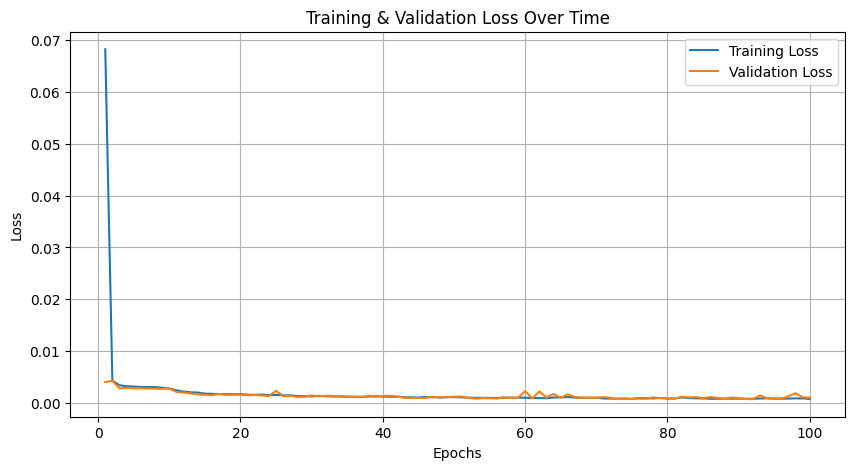

In [6]:
import matplotlib.pyplot as plt

# --- Plotting Training and Validation Loss ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()